In [2]:
import PIL.Image
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage
from scipy import stats

__all__ = \
    [
        "empty_true_color",
        "gaussian_filter",
        "get_bit_plane",
        "imhist",
        "imread",
        "imscale",
        "imshow",
        "imshow_reduced_color_depth",
        "imwrite",
        "linear_filter",
        "median_filter",
        "rank_filter",
        "zero_bit_plane"
    ]

In [3]:
def _img_a_cast(img_a, dtype, true_color=False):
    img_a = np.maximum(img_a, 0)
    img_a = np.minimum(img_a, 255)
    img_a = np.round(img_a, 0)
    img_a = np.array(img_a + 1.0e-6, dtype=dtype)
    if len(img_a.shape) == 2:
        if true_color:
            img_a_gs = np.zeros((img_a.shape[0], img_a.shape[1], 3),
                                dtype=dtype)
            for k in range(3):
                img_a_gs[:, :, k] = img_a
            return img_a_gs
        else:
            return img_a
    else:
        if len(img_a.shape) != 3 or img_a.shape[2] != 3:
            raise RuntimeError("Unexpected image type")
        return img_a

def imread(filename):
    img = PIL.Image.open(filename, "r")

    return np.array(img, dtype=np.int64)

def imscale(img_a, factor, interpolation="nearest"):
    M, N = img_a.shape[:2]
    M_scaled = int(max(round(M * factor, 0), 1) + 1.0e-6)
    N_scaled = int(max(round(N * factor, 0), 1) + 1.0e-6)

    img_a = _img_a_cast(img_a, dtype=np.uint8)
    img = PIL.Image.fromarray(img_a)
    img = img.resize((M_scaled, N_scaled),
                     resample={"nearest": PIL.Image.NEAREST,
                               "bilinear": PIL.Image.BILINEAR,
                               "bicubic": PIL.Image.BICUBIC,
                               "lanczos": PIL.Image.LANCZOS}[interpolation])

    return np.array(img, dtype=np.int64)

def imshow(img_a, new_figure=True):
    img_a = _img_a_cast(img_a, dtype=np.uint8, true_color=True)

    if new_figure:
        plt.figure()
    plt.imshow(img_a)
    plt.xticks([])
    plt.yticks([])

def linear_filter(img_a, W, **kwargs):
    img_a = _img_a_cast(img_a, dtype=np.int64)
    W = np.fliplr(np.flipud(W))

    if len(img_a.shape) == 2:
        img_filtered_a = scipy.ndimage.convolve(img_a, W, **kwargs)
    else:
        assert len(img_a.shape) == 3
        assert img_a.shape[2] == 3
        img_filtered_a = np.zeros_like(img_a)
        for k in range(3):
            img_filtered_a[:, :, k] = scipy.ndimage.convolve(
                img_a[:, :, k], W, **kwargs)

    return _img_a_cast(img_filtered_a, dtype=np.int64)

def gaussian_filter(img_a, sigma, **kwargs):
    img_a = _img_a_cast(img_a, dtype=np.int64)

    if len(img_a.shape) == 2:
        img_filtered_a = scipy.ndimage.gaussian_filter(
            img_a, sigma, **kwargs)
    else:
        assert len(img_a.shape) == 3
        assert img_a.shape[2] == 3
        img_filtered_a = np.zeros_like(img_a)
        for k in range(3):
            img_filtered_a[:, :, k] = scipy.ndimage.gaussian_filter(
                img_a[:, :, k], sigma, **kwargs)

    return _img_a_cast(img_filtered_a, dtype=np.int64)

In [9]:
filename = "/Users/lorenzostigliano/Documents/University/4th_Year/Maths_Project/Notebook"

In [10]:
image_camera = imread(filename+"/cameraman.png")

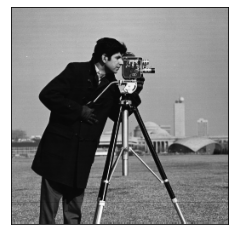

In [11]:
imshow(image_camera)

In [12]:
image_camera.shape

(256, 256)

In [13]:
n = 15

W = np.eye(n)/n

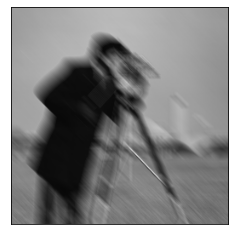

In [14]:
img_filtered_a = linear_filter(image_camera, W)
imshow(img_filtered_a)

In [15]:
D_1 = np.array([-1]+[1]+[0 for i in range(254)])
D_256 = np.array([0 for i in range(254)]+[-1]+[1])
D = D_1
for i in range(254):
    D_i = np.array([0 for i in range(i)]+[-1,0,1]+[0 for i in range(253-i)])
    D = np.vstack((D,D_i))

D = np.vstack((D,D_256))
D

array([[-1,  1,  0, ...,  0,  0,  0],
       [-1,  0,  1, ...,  0,  0,  0],
       [ 0, -1,  0, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  0,  1,  0],
       [ 0,  0,  0, ..., -1,  0,  1],
       [ 0,  0,  0, ...,  0, -1,  1]])

## Image denoising 

(None, None)

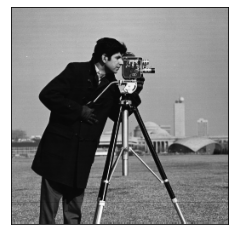

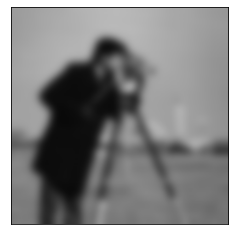

In [16]:
image_camera = imread(filename+"/cameraman.png")
img_noisy = gaussian_filter(image_camera,5)

imshow(image_camera), imshow(img_noisy)

(None, None)

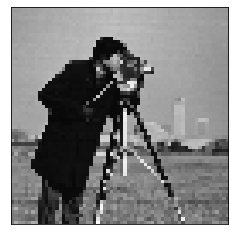

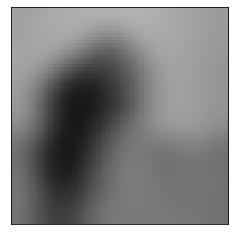

In [17]:
image_camera = imscale(image_camera,0.25)
img_noisy = gaussian_filter(image_camera,5)

imshow(image_camera), imshow(img_noisy)

In [18]:
def prior_J_TV(X,n):
    first = np.array([-1]+[1]+[0 for i in range(n-2)])
    last = np.array([0 for i in range(n-2)]+[-1]+[1])
    D = first
    for i in range(n-2):
        D_i = np.array([0 for i in range(i)]+[-1,0,1]+[0 for i in range(n-3-i)])
        D = np.vstack((D,D_i))

    D = np.vstack((D,last))
    
    n, m = D.shape
    X_D_t = X@D.T
    D_X = D@X
    
    sum = 0
    for i in range(m):
        for j in range(n):
            sum = sum + np.sqrt(((X_D_t)[i,j])**2 + ((D_X)[i,j])**2)
    return sum
            

In [19]:
prior_J_TV(img_noisy,img_noisy.shape[0])

29939.898296733933

In [68]:
def likelihood_image(X,n):
    return stats.multivariate_normal(X.flatten(), np.eye(n*n))

In [23]:
likelihood_image(img_noisy,img_noisy.shape[0])

64

In [37]:
def proposed_density_random_walk(u_t, beta, n):
    return stats.multivariate_normal(u_t,np.eye(n*n)*beta**2)

In [47]:
def MH_A_image(beta, N, X):
    """
    Implementation of Metropolis Hastings Algorithm with random walk proposed density.
    
    1. Choose u(1) with π(u(1))>0.
    2. At state u(t), sample a proposal u′ from density q(u′|u(t)).
    3. Accept sample u′ with probability:
        α(u′|u(i)) = min(1,π(u′)q(u(t)|u′)/π(u(i))q(u′|u(t))).
        
    Inputs:
    beta (float) = beta used in random walk proposed density
    N (Int) = Number of steps taken in algorthim
    
    FOR IMAGE DENOISING:
    1 - posterior distirbution = likelihood*proir
    2 - what would the proposed_density_random_walk be?
    3 - likelihood mention issues with .flatten()
    
    """
    # initalize
    n = X.shape[0]
    u_0 = [0]*(n*n) 
    u_t = [0]*(n*n) 
    
    likelihood = likelihood_image(X,n)
    
    #This has to change : posterior_distribution_pi = likelihood*proir
    def posterior_distribution_pi(x):
        return likelihood.pdf(x)*prior_J_TV(X,n)
    
    u_samples = [u_0]
    all_samples = [u_0]
    list_acceptance_probaility = []
    
    # Some cases theory; normal distribution we can calculte it -> Average acceptance rate 0.234.
    beta = beta
    
    for t in range(N):
        
        # sample a proposal u′ from density q(u′|u(t)) 
        proposal_density_t = proposed_density_random_walk(u_t,beta,n)
        u_prime = proposal_density_t.rvs()
        
        # proposal density q(u(t)|u′) used in (3)
        proposal_density_prime = proposed_density_random_walk(u_prime,beta,n)
        
        # π(u′)q(u(t)|u′)
        numerator = posterior_distribution_pi(u_prime)*proposal_density_prime.pdf(u_t)
        # π(u(t))q(u′|u(t))
        denominator = posterior_distribution_pi(u_t)*proposal_density_t.pdf(u_prime)
        
        acceptance_probaility = float(min([1,numerator/denominator]))
        list_acceptance_probaility.append(acceptance_probaility)
        
        rv = np.random.uniform(0,1,1)
        
        if rv <= acceptance_probaility:
            #Accept
            u_t = u_prime
            u_samples.append(u_t)
            all_samples.append(u_t)
        else:
            #Reject
            u_t = u_t
            all_samples.append(u_prime)
        print(t)
    
    return u_samples, all_samples, list_acceptance_probaility

In [55]:
u_samples, all_samples, list_acceptance_probaility = MH_A_image(1, 400, img_noisy)


KeyboardInterrupt: 

In [83]:
def MAP(list_x, X):
    """
    maxmise(p(x|y)) = maxmise(p(y|x)*p(x)) for x which we sample from MH algorithm
    Where y is the observation and x is the original image 
    
    Input: list_x (List of samples from MH for the image)
    Output: x (np.array that maximises the posterior probability)
    
    """
    n = X.shape[0]
    lh = likelihood_image(X,n)
    x_best = 0 
    
    for x in list_x:
        max_value = -100000
        if lh.pdf(np.asarray(x))*prior_J_TV(np.asarray(x).reshape(64,64),64) > max_value:
            x_best = x
    return x_best

In [86]:
best_img = MAP(u_samples, img_noisy)
best_img

array([ 38.77335116, -18.60380789, -14.29751109, ...,  -4.6691307 ,
        16.35401609, -18.28612149])

(None, None)

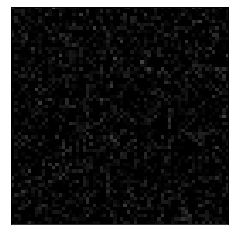

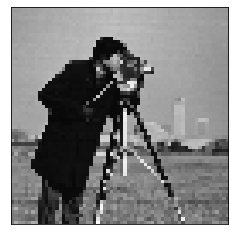

In [87]:
imshow(best_img.reshape(64,64),64) , imshow(image_camera)